1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

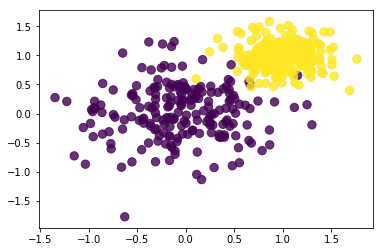

In [2]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

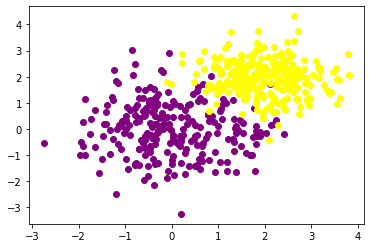

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

# n_cat1 = np.random.normal(loc=0., scale=1., size=(100,))
# n_cat2 = np.random.normal(loc=2., scale=1.5, size=(100,))

# print(n_cat1)
# print(n_cat2)

mean, cov = [0, 0], [(1, 0), (0, 1)]
data_cat1 = np.random.multivariate_normal(mean, cov, 250)


mean, cov = [2, 2], [(.5, 0), (0, .5)]
data_cat2 = np.random.multivariate_normal(mean, cov, 250)

fig, _ = plt.subplots( figsize=(6, 4))

plt.scatter(x=data_cat1[:, 0], y=data_cat1[:, 1], marker='o', c='purple')
plt.scatter(x=data_cat2[:, 0], y=data_cat2[:, 1], marker='o', c='yellow')


2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

residuals has a distribution similar to a gaussian


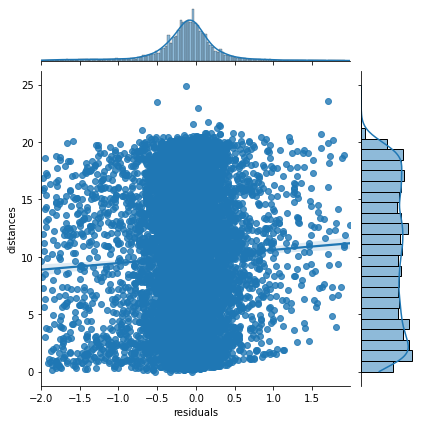

In [4]:
import pandas as pd
import seaborn as sns

data = pd.read_pickle("data/residuals_261.pkl")

df = pd.DataFrame(data.item(0))
# display(df)

df_filtered = df[df['residuals'].abs() < 2]
# display(df_filtered)

g = sns.jointplot(x="residuals", y="distances", data=df_filtered, kind="reg")

print("residuals has a distribution similar to a gaussian")


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25.]
[-0.23790635 -0.14007174 -0.1769304  -0.15851317 -0.12823252 -0.13562386
 -0.10279383 -0.07876432 -0.0926284  -0.09227192 -0.05149577 -0.10439892
 -0.09263436 -0.13268737 -0.15230155 -0.13734682 -0.13364765 -0.1598939
 -0.12144452 -0.05150568  0.03768483  0.05111111  0.02857143  0.41285714
 -0.12857143]


<ErrorbarContainer object of 3 artists>

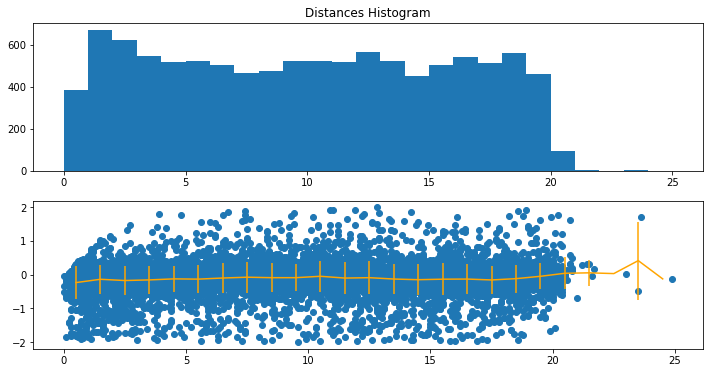

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6)) # create the figure and the axes
h, bins, _ = ax1.hist(df_filtered['distances'], bins=25, range=(0, 25), density=False, cumulative=False)

ax1.set_title('Distances Histogram')

print(bins)

x = (bins[1:] + bins[:-1]) / 2
y = []
err_y = []
for i in range(len(bins)-1):
    mask = (df_filtered['distances'] >= bins[i]) & (df_filtered['distances'] <= bins[i+1])
    y.append(df_filtered[mask]['residuals'].mean())
    err_y.append(df_filtered[mask]['residuals'].std())

x = np.array(x)
y = np.array(y)
print(y)
err_y = np.array(err_y)

ax2.scatter(x=df_filtered['distances'], y= df_filtered['residuals'], marker='o')
ax2.errorbar(x=x, y=y, yerr=err_y, c='orange')




3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


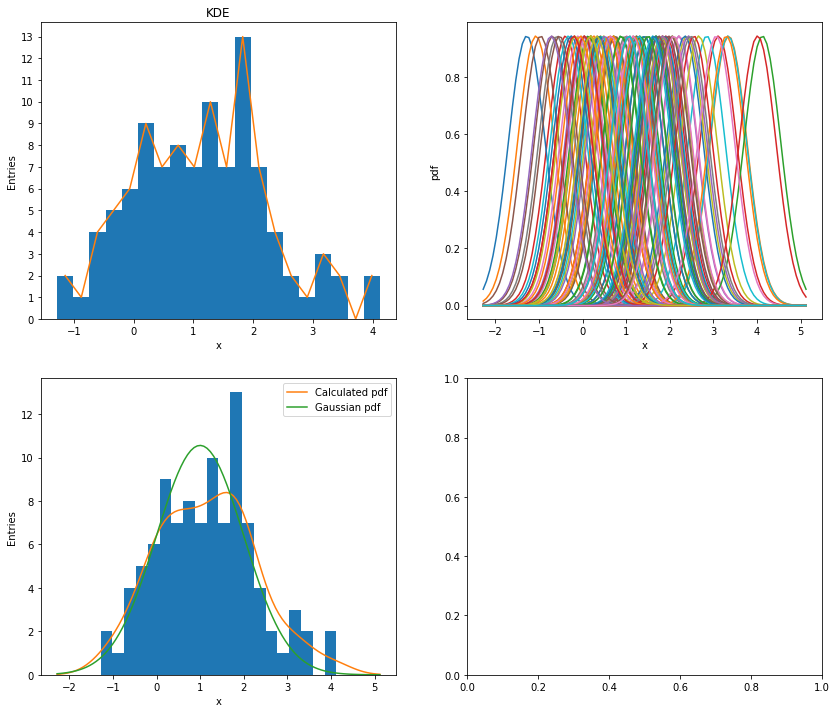

In [142]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm, poisson
from scipy import integrate

size = 100
mean = 1
std = 1
nbins = 20

x = np.random.normal(loc=mean, scale=std, size=(size,))

fig, (ax, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 

h, bins, _ = ax[0].hist(x, bins=nbins)
ax[0].set_title('KDE')
ax[0].set_ylabel('Entries')
ax[0].set_xlabel('x')



ax[0].yaxis.set_major_locator(MultipleLocator(1))

bin_centres = (bins[:-1] + bins[1:])/2.

hist_area = integrate.trapz(h, bin_centres)

# ax[0].plot(bin_centres, norm.pdf(bin_centres, loc=mean, scale=std) * hist_area)

h_err =abs( h - norm.pdf(bin_centres, loc=mean, scale=std) * hist_area)
h_err_poisson = poisson.pmf( h_err, mean)
ax[0].errorbar(bin_centres, h, yerr=h_err_poisson)


ax[1].set_ylabel('pdf')
ax[1].set_xlabel('x')

lin_s = np.linspace(x.min()-1, x.max()+1, num=100)

summed_pdf = np.zeros(lin_s.shape)
std_x =1.06*std*(size**(-1/5))
for e in x:
    ax[1].plot(lin_s, norm.pdf(lin_s, loc=e, scale=std_x))
    
    summed_pdf = summed_pdf + norm.pdf(lin_s, loc=e, scale=std_x)

    
hist_area = integrate.trapz(h, bin_centres)
final_area = integrate.trapz(summed_pdf, lin_s)
summed_pdf = summed_pdf / final_area * hist_area

final_area = integrate.trapz(h, bin_centres)
ax2[0].hist(x, bins=nbins, density=False)
ax2[0].plot(lin_s, summed_pdf , label = "Calculated pdf")
ax2[0].plot(lin_s, norm.pdf(lin_s, loc=mean, scale=std) * hist_area, label = "Gaussian pdf")
ax2[0].set_ylabel('Entries')
ax2[0].set_xlabel('x')
ax2[0].legend()
